In [1]:
# %config InlineBackend.figure_formats = ['svg']
import xyzpy as xyz
import combo_dynamics
from combo_dynamics import *
from math import pi
import quimb.tensor as qtn
import numpy as np
import os
from quimb.tensor.circuit import *
from quimb.tensor.circuit import Gate
from quimb.tensor.tensor_1d import maybe_factor_gate_into_tensor
import torch
import pickle

# set single thread
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
# specify which gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


def coor2index(i, j, Lx, Ly):
    return i * Ly + j


def index2coor(index, Lx, Ly):
    return index // Ly, index % Ly


def tag_initial_state(psi, Lx, Ly):
    psi0 = psi.copy()
    for i in range(Lx * Ly):
        psi0.tensors[i].add_tag(['PSI0', 'ROUND_0'])
    return psi0


def peps2circpsi(peps, Lx, Ly):
    psi0 = peps.copy()
    for i in range(Lx * Ly):
        # psi0.tensors[i].add_tag(['PSI0','ROUND_0'])
        psi0.reindex_({"k{},{}".format(*index2coor(i, Lx, Ly)): f"k{i}"})
        psi0.retag_({'I{},{}'.format(*index2coor(i, Lx, Ly)): f"I{i}"})
    circ0 = Circuit(Lx * Ly, tags=['ROUND_0'])
    psi0.view_like_(circ0.psi)
    return psi0


def circpsi2peps(psi, Lx, Ly):
    peps0 = psi.copy()
    for i in range(Lx * Ly):
        peps0[f'I{i}'].add_tag([
            'X{}'.format(index2coor(i, Lx, Ly)[0]),
            'Y{}'.format(index2coor(i, Lx, Ly)[1])
        ])
        peps0.retag_({f"I{i}": "I{},{}".format(*index2coor(i, Lx, Ly))})
        peps0.reindex_({f"k{i}": "k{},{}".format(*index2coor(i, Lx, Ly))})

    peps = qtn.PEPS.from_TN(
        peps0,
        Lx=Lx,
        Ly=Ly,
        site_tag_id='I{},{}',
        site_ind_id='k{},{}',
        x_tag_id='X{}',
        y_tag_id='Y{}',
    )
    return peps


def to_backend(x):
    # return torch.tensor on gpu
    return torch.tensor(x, dtype=torch.float64, device='cuda')


def site_ind(i, j=None, site_ind_id='k{}', Lx=4, Ly=2):
    """Return the physical index of site ``(i, j)``."""
    if j is None:
        i, j = i
    if not isinstance(i, str):
        i = i % Lx
    if not isinstance(j, str):
        j = j % Ly
    ind = coor2index(i, j, Lx, Ly)
    return site_ind_id.format(ind)


def compute_energy(ham, psi):
    psi0 = psi.copy()
    norm = psi0.H & psi0
    terms = ham.terms
    energy = 0
    for where, h in terms.items():
        site_ix = [site_ind(i, j) for i, j in where]
        op = h
        ng = len(site_ix)
        G = maybe_factor_gate_into_tensor(op, dp=2, ng=ng, where=where)
        # new indices to join old physical sites to new gate
        bnds = [rand_uuid() for _ in range(ng)]
        reindex_map = dict(zip(site_ix, bnds))
        TG = Tensor(G, inds=site_ix + bnds, left_inds=bnds)
        norm = psi0.H @ psi0
        psi1 = psi0.copy()
        psi1.reindex_(reindex_map)
        expec = (psi1 | TG | psi0.H).contract() / norm
        energy += expec
    return energy

/home/sijingdu/anaconda3/envs/BPSU/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [38]:
depth = 120
tau_list = [0.5, 0.1, 0.03, 0.01]
max_bond = D_init = 2
Lx = 4
Ly = 2
j = (1, 1, 1)
g = 0
ordering = pickle.load(open('./ordering.pkl', 'rb'))
compute_energy_every = 20

state_vector_energy_list = []
iter_list = []

H2 = qu.ham_heis(n=2, j=j)
if g != 0:
    H1 = qu.ham_heis(n=1, b=(0, 0, g))
    ham = qtn.LocalHam2D(Lx, Ly, H2=H2, H1=H1)
else:
    ham = qtn.LocalHam2D(Lx, Ly, H2=H2)


#Manually construct the imaginary time evolution circuit, may contain bugs!!
psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=max_bond,
                     seed=666)  # How to choose the seed?
psi0 = peps2circpsi(psi0, Lx, Ly)
circ = Circuit(Lx * Ly, psi0=psi0, tags=['ROUND_0'])
step = 0
for tau in tau_list:
    if tau == tau_list[-1]:
        depth_tau = 200
    else:
        depth_tau = depth
    for r in range(depth_tau):
        step += 1
        for where in tuple(ordering):
            qubits = (coor2index(*where[0], Lx,
                                 Ly), coor2index(*where[1], Lx, Ly))
            U = ham.get_gate_expm(where, -tau)
            circ.apply_gate(U,
                            *qubits,
                            gate_round=r + depth_tau * tau_list.index(tau),
                            parametrize=None,
                            params=tau,
                            contract='split-gate')
        if (step + 1) % compute_energy_every == 0:
            circ._psi.equalize_norms_()
            psi0 = circ.psi.copy().contract()
            energy = compute_energy(ham, psi0)
            state_vector_energy_list.append(energy)
            iter_list.append(step)


### SU

In [77]:

its_list = []
energy_list = []
D_list = [4,8,12,16,20]
for D in D_list:
    print('D:', D)
    init_peps = qtn.PEPS.rand(Lx, Ly, bond_dim=D_init, seed=666)

    # ham.apply_to_arrays(to_backend)
    # init_peps.apply_to_arrays(to_backend)
    su = qtn.SimpleUpdate_exact_energy(
        init_peps,
        ham,
        chi=128,  # boundary contraction bond dim for computing energy
        compute_energy_every=compute_energy_every,
        compute_energy_per_site=True,
        keep_best=True,
        second_order_reflect=False,
        ordering=ordering,
        D=D,
        gate_opts={'cutoff':0.0}
    )

    for tau in tau_list:
        if tau == tau_list[-1]:
            depth_tau = 200
        else:
            depth_tau = depth
        su.evolve(depth_tau, tau=tau)

    its_list.append(su.its)
    energy_list.append(su.energies)

D: 4


n=560, tau=0.0100, energy~-0.529695: 100%|##########| 200/200 [00:01<00:00, 196.24it/s]


D: 8


n=560, tau=0.0100, energy~-0.534716: 100%|##########| 200/200 [00:01<00:00, 178.69it/s]


D: 12


n=560, tau=0.0100, energy~-0.535772: 100%|##########| 200/200 [00:02<00:00, 71.85it/s]


D: 16


n=560, tau=0.0100, energy~-0.536116: 100%|##########| 200/200 [00:03<00:00, 61.93it/s]


D: 20


n=560, tau=0.0100, energy~-0.535919: 100%|##########| 200/200 [00:08<00:00, 22.36it/s]


In [4]:
import quimb as qu

energy_exact = qu.groundenergy(qu.ham_heis_2D(Lx, Ly, sparse=True)) / (Lx * Ly)
energy_exact

-0.5366333070821335

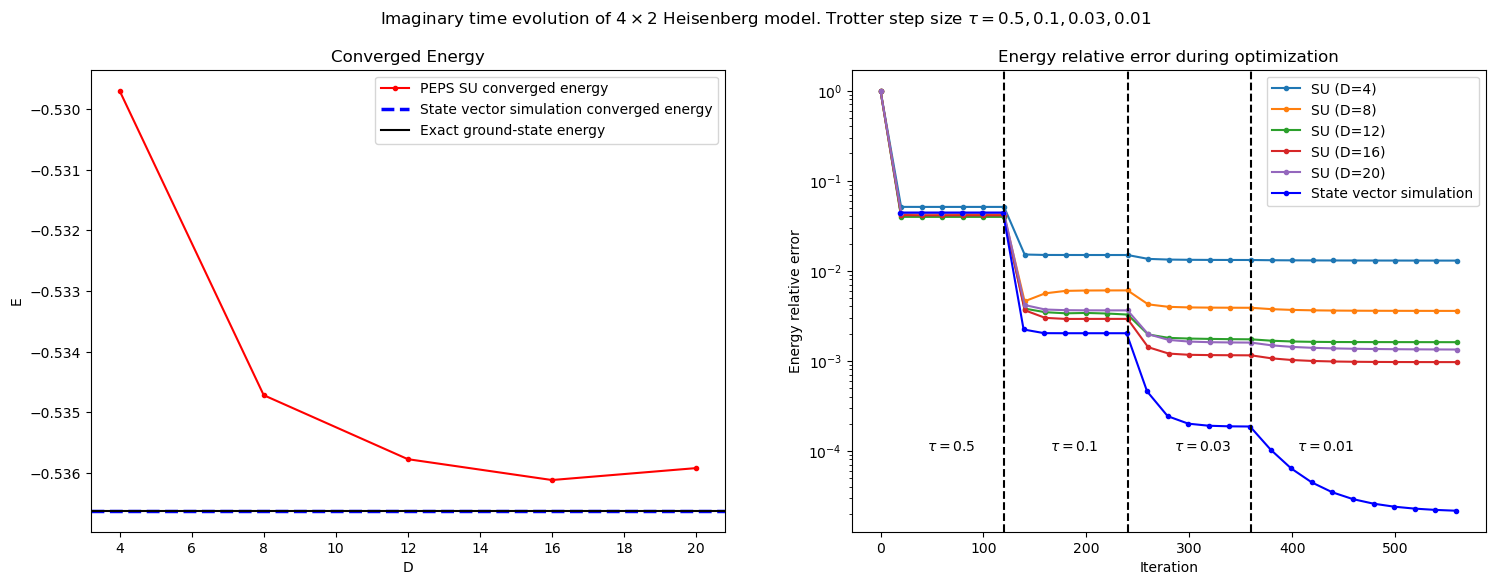

In [78]:
import matplotlib.pyplot as plt
import numpy as np

state_vector_energy_per_site_list = np.array(state_vector_energy_list) / (Lx * Ly)


relative_error = np.abs(state_vector_energy_per_site_list - energy_exact) / np.abs(energy_exact)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

converged_energy_list = []
for D in D_list:
    converged_energy_list.append(energy_list[D_list.index(D)][-1])
    # ax[0].plot(its_list[D_list.index(D)], energy_list[D_list.index(D)], '.-', label='SU (D=%d)' % D)
    ax[1].plot(its_list[D_list.index(D)], np.abs(energy_list[D_list.index(D)] - energy_exact) / np.abs(energy_exact), '.-', label='SU (D=%d)' % D)


# ax[0].plot(iter_list,
#            state_vector_energy_per_site_list,
#            '.-',
#            label='State vector simulation')
ax[0].plot(D_list, converged_energy_list, '.-', label='PEPS SU converged energy', color='r')
ax[0].axhline(state_vector_energy_per_site_list[-1], color='blue', linestyle='--', label='State vector simulation converged energy',linewidth=2.5)
ax[0].axhline(energy_exact, color='black', linestyle='-', label='Exact ground-state energy')
ax[0].set_xlabel('D')
ax[0].set_ylabel('E')
ax[0].set_title('Converged Energy')

ax[1].plot(iter_list, relative_error, '.-', label='State vector simulation', color='b')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Energy relative error')
ax[1].set_title('Energy relative error during optimization')
ax[1].set_yscale('log')
# add text of the step size tau on the plot
ax[1].text(60-15, 1e-4, r'$\tau=0.5$', fontsize=10)
ax[1].text(180-15, 1e-4, r'$\tau=0.1$', fontsize=10)
ax[1].text(300-15, 1e-4, r'$\tau=0.03$', fontsize=10)
ax[1].text(420-15, 1e-4, r'$\tau=0.01$', fontsize=10)
# plot vertical lines at [120, 240, 360]
ax[1].axvline(120, color='black', linestyle='--')
ax[1].axvline(240, color='black', linestyle='--')
ax[1].axvline(360, color='black', linestyle='--')
# add the legend of \tau to indicate it is the step size


ax[0].legend()
ax[1].legend()

plt.suptitle(r'Imaginary time evolution of $4\times 2$ Heisenberg model. Trotter step size $\tau=0.5,0.1,0.03,0.01$')
plt.savefig('SU_convergence_4x2.png', dpi=300, bbox_inches='tight')
plt.show()

In [133]:
psi = circ.psi.copy().contract()

In [136]:
compute_energy(ham, psi) / (Lx * Ly)

-0.5366178071153233